# 1. SETUP

## 1.1 Imports


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_continuous import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

## 1.2 PARAMETERS SETUP


In [2]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("InvertedPendulum-v4", max_episode_steps=1000) ## Continuous case
    states = []
    # get an initial state
    state, info = env.reset()
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(6):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 200000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
env = gym.make("InvertedPendulum-v4") ## Continuous case
env_eval = gym.make("InvertedPendulum-v4") ## Continuous case
obs_shape = env.observation_space.shape[0]
action_space_dims = 1 ## Continuous case ==> 1 dimension of action space: continuous force between [-3, 3] Newton
print("Action space: ", env.action_space)

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")


# AGENT
#All observations start in state (0.0, 0.0, 0.0, 0.0) with a uniform noise in the 
#range of [-0.01, 0.01] added to the values for stochasticity.
agent = A2C(obs_shape, action_space_dims, device, critic_lr, actor_lr, n_envs)

Action space:  Box(-3.0, 3.0, (1,), float32)


# 2. AGENT TRAINING

In [3]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
entropies = []
episode_returns = []
steps_episodes = [] # logs the steps taken in each episode
evaluation_returns = [] # logs the returns of the agent during evaluation
values = [] # logs the values of the agent on the fixed trajectory

# COUNTERS
steps = 0
ep_counter = 0
ep_reward = 0

# VARIABLE INITIALIZATION
is_truncated = False
is_terminated = False
states, info = env.reset(seed=seed_value) #only use the seed when resetting the first time
##fixed_trajectory = getTrajectory() ## Implementation of continuous case
#values = np.array(n_evaluations,len(fixed_trajectory)) # log the values over a trajectory

# use tqdm to get a progress bar for training
for steps in tqdm(range(n_updates+1)):
        

    # reset lists that collect experiences of a n_steps_per_update
    n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    # don't take mask and reward gradient
    masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
    n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
    end_states = []
    end_states_idx = [0]

    # play n_steps_per_update to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
        #actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False) ## Should be updated for continuous action space
        actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

        # ensure no grad is taken in the step
        with torch.no_grad():
            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            states, reward, is_terminated, is_truncated, infos = env.step(
                actions.cpu().numpy()
            )
        if stochasticity_bool:
            # introduce stochasticity in the reward
            if np.random.rand() < stochastic_reward_probability:
                reward = 0

        ep_reward += reward # increase episode return
        mask = not is_terminated # define mask for bootstrapping

        # log the value, reward and action log prob of the last step
        n_value_preds[step] = torch.squeeze(V_t)
        n_rewards[step] = torch.tensor(reward, device=device)
        n_action_log_probs[step] = action_log_probs

        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor(mask) # allows for correct bootstrapping
        
        # reset environment if truncated or terminated
        if is_terminated or is_truncated:
            states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
            end_states.append(states_tensor)
            end_states_idx.append(step)
            states, info = env.reset() # do not use the seed when resetting again
            ep_counter += 1
            steps_episodes.append(steps)
            episode_returns.append(ep_reward)
            ep_reward = 0

    
    # if statement to make sure we don't append the end state twice
    if not is_terminated and not is_truncated:
        states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
        end_states.append(states_tensor)
        end_states_idx.append(step)

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        n_rewards,
        n_action_log_probs,
        n_value_preds,
        #entropy,
        masks,
        gamma,
        end_states,
        end_states_idx
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())
    """
    #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
    #on a newly initialized environment and plotting the evaluation statistics below.
    with torch.no_grad(): # No need to store gradients in the evaluation
        if steps % evaluation_interval == 0:
            print("EVALUATION")
            # evaluate
            returns = []
            episode_lengths = []
            for i in range(n_eval_runs):
                # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                if i == 0:
                    state, info = env_eval.reset(seed = seed_value)
                    value = []
                    for state_traj in fixed_trajectory:
                        _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False) ## Should be updated for continuous action space
                        value.append(V_t)
                    values.append(value)
                else:
                    state, info = env_eval.reset()
                episode_return = 0
                episode_length = 0
                while True:
                    action, _, _, _ = agent.select_action(state,bool_greedy=True) ## Should be updated for continuous action space
                    state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                    episode_return += reward
                    episode_length += 1
                    if terminated or truncated:
                        break
                returns.append(episode_return)
                episode_lengths.append(episode_length)  
            print(returns)
            evaluation_returns.append(np.mean(returns))
            """





100%|██████████| 200001/200001 [02:27<00:00, 1355.06it/s]


# 3. RESULTS

## 3.1 PLOTTING

ValueError: v cannot be empty

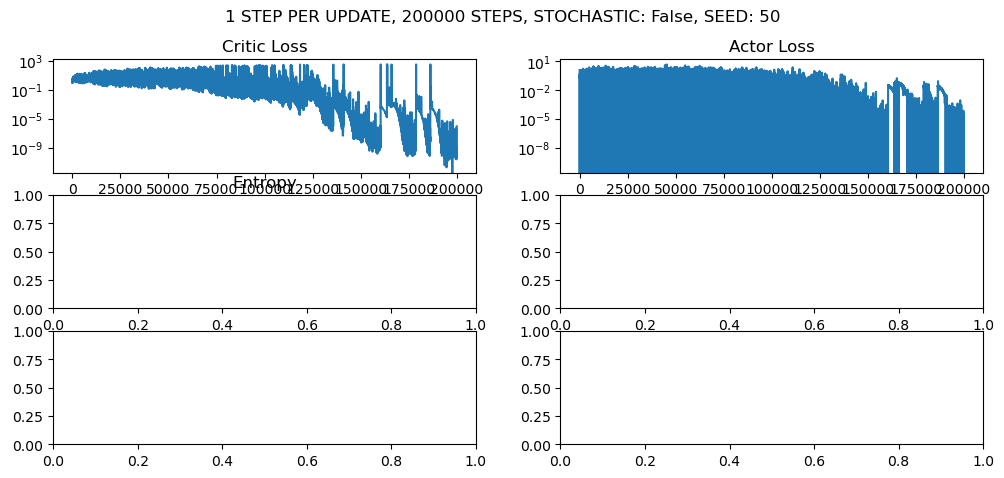

In [4]:
rolling_length = 30

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 5))
#set title of the plot
fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {seed_value}")
critic_losses = np.array(critic_losses)
capped_loss = critic_losses[critic_losses < 1]
critic_ma = (
    np.convolve(np.array(critic_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 0].plot(critic_ma)
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
actor_ma = (
    np.convolve(np.array(actor_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 1].plot(actor_ma)
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis


# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")



#axs[1, 1].plot(steps_episodes, episode_returns)
#axs[1, 1].set_title('Episode Rewards')
axs[1, 1].plot(evaluation_returns)
axs[1, 1].set_title('Evaluation Returns')

# plot the values of the agent on the fixed trajectory
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]):
    axs[2, 0].plot(values[i])
axs[2, 0].set_title('Values on the fixed trajectory')
axs[2, 0].set_xlabel('Number of updates')
axs[2, 0].set_ylabel('Value')

# plot the episode returns
axs[2, 1].plot(episode_returns)
axs[2, 1].set_title('Episode Returns')
axs[2, 1].set_xlabel('Number of episodes')
axs[2, 1].set_ylabel('Return')

plt.tight_layout()
plt.show()


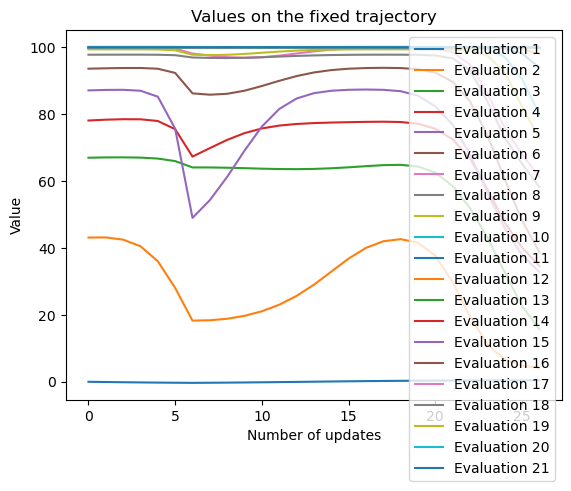

In [29]:
# plot the values of the agent on the fixed trajectory
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()


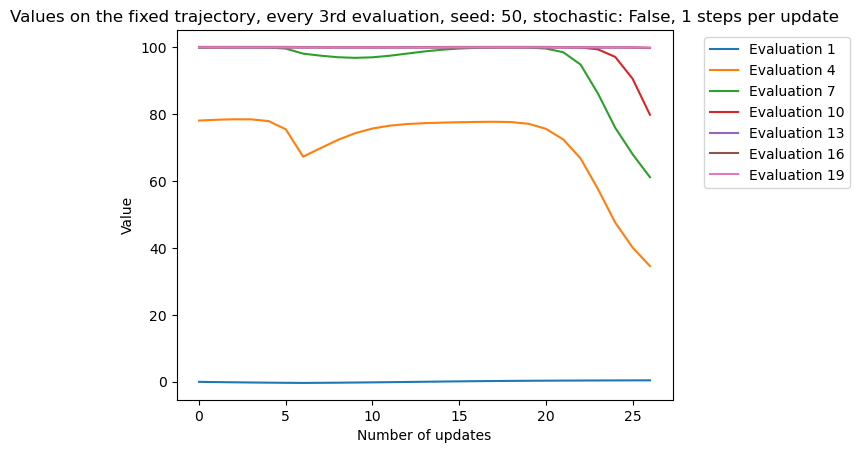

<Figure size 640x480 with 0 Axes>

In [38]:
values = np.array(values)
values = np.squeeze(values)

for i in range(0, values.shape[0], 3):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title(f'Values on the fixed trajectory, every 3rd evaluation, seed: {seed_value}, stochastic: {stochasticity_bool}, {n_steps_per_update} steps per update')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.savefig(f'figures/{n_steps_per_update}setps_step_stoch_seed{seed_value}.png', bbox_inches='tight')



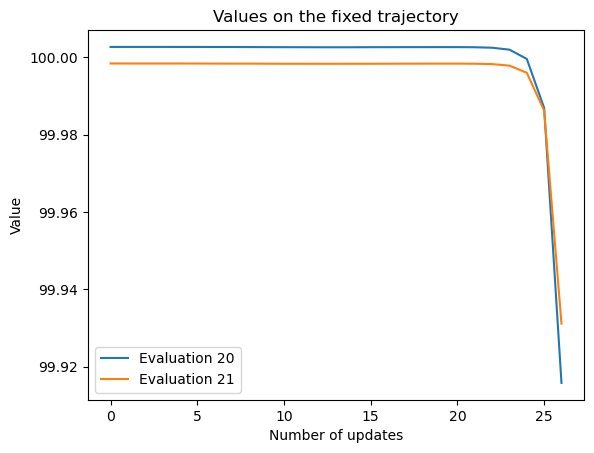

In [32]:
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]-2, values.shape[0],1):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
values = np.array(values)
values.shape

(11, 9)

In [ ]:
plt.plot(steps_episodes,episode_returns)
plt.title("episode returns")
plt.xlabel("Number of evaluations")
plt.ylabel("Return")
plt.show()

## 3.2 SAVE PLOTS

In [33]:
#save the plot
if stochasticity_bool:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_stoch_seed{seed_value}_full.png")
else:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_nostoch_seed{seed_value}_full.png")

## 3.3 SAVE/LOAD AGENT WEIGHTS

In [6]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weights_stoch.h5"
critic_weights_path = "weights/critic_weights_stoch.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## 3.4 SHOWCASE AGENT

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True) ## Should be updated for continuous action space

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 